# Introduction to CNN

CNN Microscopy Segmentation 

This notebook teaches **beginner CNN segmentation** for microscopy images.

**Objectives:**
- Learn how to create masks using OpenCV
- Train a CNN for multi-class segmentation (TensorFlow)
- Evaluate using Dice & IoU
- Improve outputs


In [13]:
## Import Required Libraries

# Operating system utilities (file paths, directory listing)
import os

# Numerical computing
import numpy as np

# Image processing with OpenCV
import cv2

# Plotting and visualization
import matplotlib.pyplot as plt

# TensorFlow / Keras for CNNs
import tensorflow as tf
from tensorflow.keras import layers, models

# Metrics helpers
from sklearn.model_selection import train_test_split


## 3. Dataset Structure

Expected folder structure:
```
Microscopy_Dataset/
 ├── images/   (.JPG microscopy images)
 └── masks/    (.png masks – generated if missing)
```

Important: Masks **do not originally exist** and must be created using OpenCV.


In [14]:

# Define base directory containing images and masks
BASE_DIR = "C:\\Users\\admin\\Desktop\\HPC_ML Course\\"

# Path to raw microscopy images
IMAGE_DIR = os.path.join(BASE_DIR, '100_images')

# Path where masks will be stored or loaded
MASK_DIR = os.path.join(BASE_DIR, 'masks')

# Create mask directory
os.makedirs(MASK_DIR, exist_ok=True)

## 4. Multi-Class Mask Generation using OpenCV


Let the input grayscale image be represented as a discrete intensity function

I : Ω ⊂ Z^2 → {0, 1, …, 255}

where Ω denotes the spatial domain of the image and I(x, y) is the pixel intensity at location (x, y).

---

## a. Noise Reduction via Gaussian Smoothing

To suppress high-frequency noise and small intensity fluctuations, the image is first smoothed using a Gaussian filter:

I_s(x, y) = (I * G_σ)(x, y)

where * denotes convolution and G_σ is a 2D Gaussian kernel defined as:

G_σ(x, y) = (1 / (2πσ²)) · exp(−(x² + y²) / (2σ²))

In practice, a 5 × 5 kernel is used, which approximates this continuous formulation locally.

---

## b. Global Thresholding Using Otsu’s Method

The smoothed image I_s is binarized using Otsu’s thresholding, which automatically determines an optimal threshold T* by maximizing the between-class variance:

T* = arg max_T σ_B²(T)

where:

σ_B²(T) = ω₀(T) · ω₁(T) · [μ₀(T) − μ₁(T)]²

Here:
- ω₀ and ω₁ are the class probabilities
- μ₀ and μ₁ are the mean intensities of the background and foreground

The resulting binary image is defined as:

B(x, y) = 1   if I_s(x, y) < T*
B(x, y) = 0   otherwise

(Note: this is inverted in implementation so pores appear as foreground.)

---

## c. Initialization of the Multi-Class Mask

A multi-class segmentation mask M(x, y) is initialized as:

M(x, y) = 0   for all (x, y) ∈ Ω

where:
- 0 represents background
- 1 represents small pores
- 2 represents large pores

All foreground pixels detected by thresholding are initially assigned to the large-pore class:

M(x, y) = 2   if B(x, y) = 1

---

## d. Contour Extraction and Area-Based Classification

Connected components (contours) are extracted from the binary image:

C = {C₁, C₂, …, C_N}

For each contour C_i, its area is computed as:

A_i = sum of all pixels belonging to C_i

A size-based rule is applied:

M(x, y) = 1   if (x, y) ∈ C_i and A_i < τ  
M(x, y) = 2   if (x, y) ∈ C_i and A_i ≥ τ

where τ = 50 pixels is an empirically chosen threshold separating small and large pores.

---

## e. Morphological Noise Removal

To eliminate isolated artifacts and smooth class boundaries, morphological opening is applied:

M' = (M ⊖ K) ⊕ K

where:
- K is a 3 × 3 structuring element
- ⊖ denotes erosion
- ⊕ denotes dilation

This operation removes small spurious regions while preserving pore structures.

---

## f. Final Output

The resulting mask:

M' : Ω → {0, 1, 2}

serves as a multi-class ground-truth segmentation map, suitable for training convolutional neural networks (CNNs) for semantic segmentation.

---

## Note

- Otsu’s method provides consistent labels across samples  
- Area-based classification encodes meaningful size information  
- Morphological filtering improves label smoothness and training stability  


In [19]:
def generate_mask(image_path, save_path):
    """
    Generate a multi-class segmentation mask using Otsu's thresholding
    and contour area analysis.
    """
    # Load image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Use Otsu's method to automatically find threshold
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Initialize mask with background class (0)
    mask = np.zeros_like(blur, dtype=np.uint8)
    mask[binary == 255] = 2  # All pores start as class 2 (large pores)

    # Separate by size using contour analysis
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 50:  # Small pores threshold
            cv2.drawContours(mask, [contour], -1, 1, -1)
        # Else you can keep as class 2 (large pores)

    # Morphological opening to remove noise
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Save the generated mask
    cv2.imwrite(save_path, mask)
    return mask


## 4.1 Analyze Sample Image Intensity Distribution

### Check if images directory exists and has files

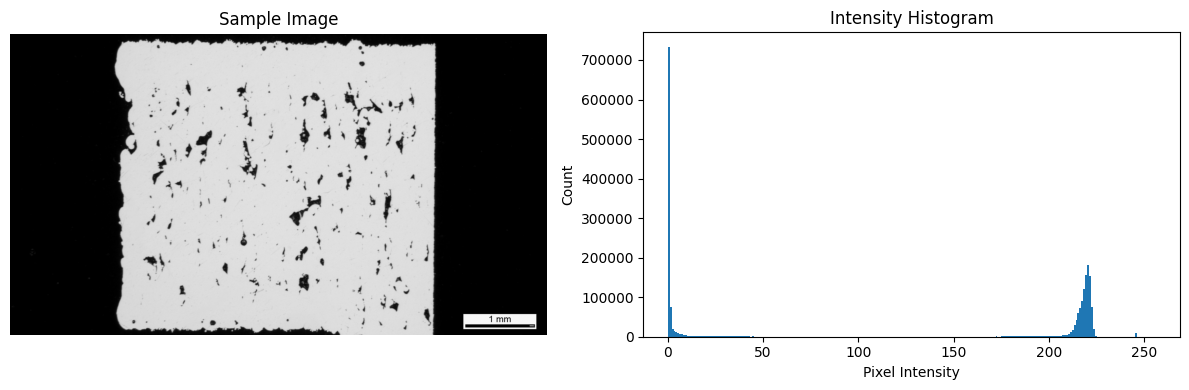

Min intensity: 0
Max intensity: 252
Mean intensity: 118.7
Found 150 images


In [18]:
# Check whether the image directory exists on disk
if not os.path.exists(IMAGE_DIR):

    # Print an error message showing the missing directory path
    print(f"ERROR: Image directory not found at {IMAGE_DIR}")

    # Instruct the user to correct the base directory path
    print("Please update BASE_DIR to point to your dataset location")

# If the image directory exists
else:
    # Create a list of all files in IMAGE_DIR that end with '.JPG'
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.JPG')]

    # Check if no JPG images were found
    if len(image_files) == 0:

        # Print an error message if the directory contains no JPG files
        print(f"ERROR: No .JPG files found in {IMAGE_DIR}")

    # If at least one image file is found
    else:
        # Load the first image in grayscale mode using OpenCV
        sample_img = cv2.imread(
            os.path.join(IMAGE_DIR, image_files[0]),  # Full path to the image
            cv2.IMREAD_GRAYSCALE                      # Load image as grayscale
        )

        # Create a new matplotlib figure with specified width and height
        plt.figure(figsize=(12, 4))

        # Create the first subplot (1 row, 2 columns, position 1)
        plt.subplot(1, 2, 1)

        # Display the grayscale image
        plt.imshow(sample_img, cmap='gray')

        # Set the title for the image plot
        plt.title('Sample Image')

        # Remove axis ticks and labels for cleaner visualization
        plt.axis('off')

        # Create the second subplot (1 row, 2 columns, position 2)
        plt.subplot(1, 2, 2)

        # Plot a histogram of pixel intensities
        # sample_img.ravel() flattens the image into a 1D array
        plt.hist(sample_img.ravel(), bins=256, range=[0, 256])

        # Set the title of the histogram
        plt.title('Intensity Histogram')

        # Label the x-axis (pixel intensity values)
        plt.xlabel('Pixel Intensity')

        # Label the y-axis (frequency of each intensity)
        plt.ylabel('Count')

        # Automatically adjust spacing between subplots
        plt.tight_layout()

        # Display the figure on screen
        plt.show()

        # Print the minimum pixel intensity in the image
        print(f"Min intensity: {sample_img.min()}")

        # Print the maximum pixel intensity in the image
        print(f"Max intensity: {sample_img.max()}")

        # Print the mean pixel intensity (formatted to one decimal place)
        print(f"Mean intensity: {sample_img.mean():.1f}")

        # Print the total number of JPG images found in the directory
        print(f"Found {len(image_files)} images")


## 4.2 Generate All Masks

### Generate masks for all images

In [21]:
# Print a message to indicate that mask generation has started
print("Generating masks...")

# Initialize a counter to keep track of how many masks are created
mask_count = 0

# Loop through all files in the image directory
for fname in os.listdir(IMAGE_DIR):

    # Check if the current file is a JPG image
    if fname.endswith('.JPG'):

        # Create the full file path to the input image
        img_path = os.path.join(IMAGE_DIR, fname)

        # Create the full file path where the mask will be saved
        # The file extension is changed from .JPG to .png
        mask_path = os.path.join(
            MASK_DIR,
            fname.replace('.JPG', '.png')
        )

        # Check if the mask file already exists
        # This prevents regenerating masks unnecessarily
        if not os.path.exists(mask_path):

            # Generate the segmentation mask from the image
            generate_mask(img_path, mask_path)

            # Increase the counter since a new mask was created
            mask_count += 1

# Print how many new masks were generated
print(f"Generated {mask_count} new masks")


Generating masks...
Generated 0 new masks


## 4.3 Visualize Generated Masks

### Visualize a few masks

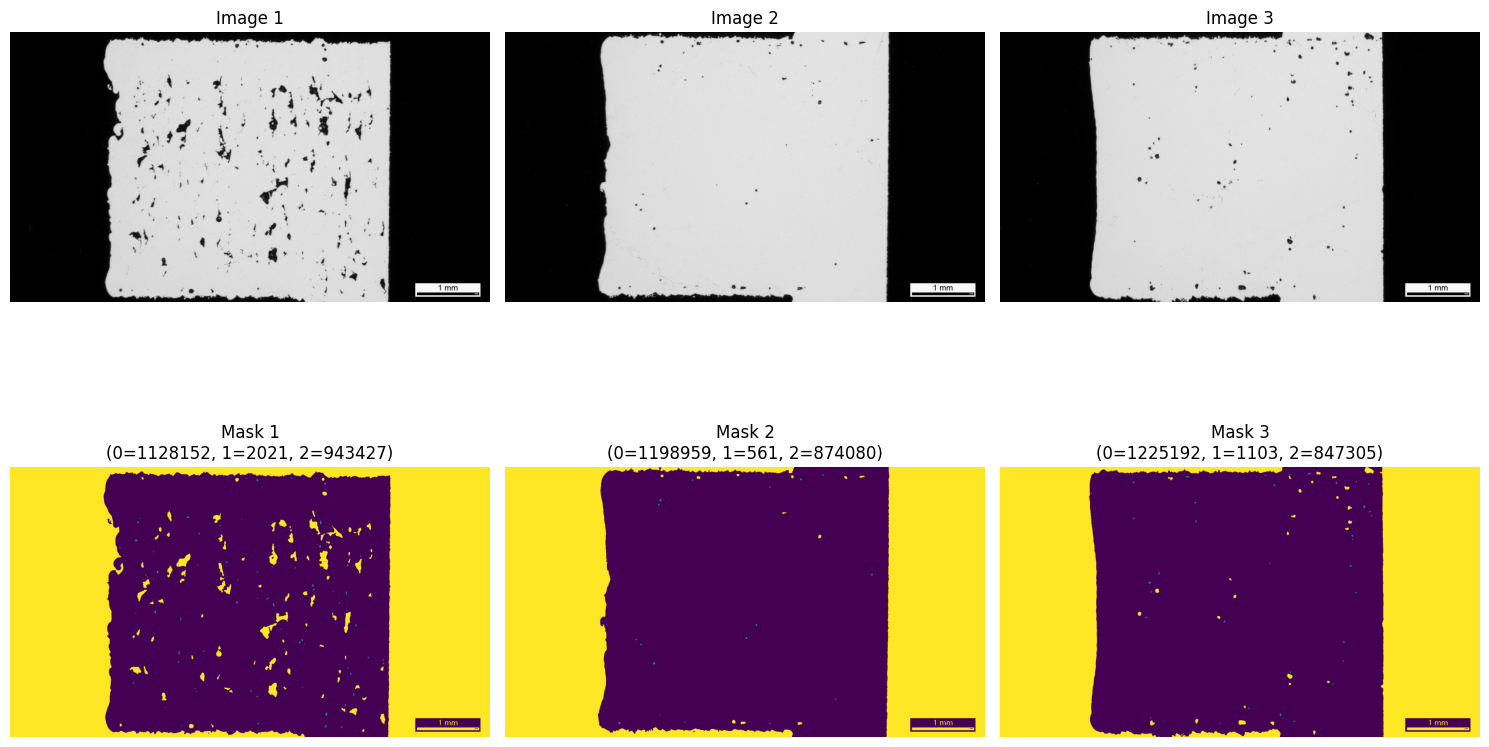

In [22]:
# Get a list of all JPG image files in the image directory
# The [:3] limits the list to the first three images only
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.JPG')][:3]

# Check that at least one image was found
if len(image_files) > 0:

    # Create a figure with 2 rows and 3 columns of subplots
    # The figure size controls how large the plots appear
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Loop over the selected image files with an index
    for i, fname in enumerate(image_files):

        # Load the image in grayscale mode
        img = cv2.imread(
            os.path.join(IMAGE_DIR, fname),
            cv2.IMREAD_GRAYSCALE
        )

        # Load the corresponding mask image in grayscale mode
        # The file extension is changed from .JPG to .png
        mask = cv2.imread(
            os.path.join(MASK_DIR, fname.replace('.JPG', '.png')),
            cv2.IMREAD_GRAYSCALE
        )

        # Display the original image in the top row
        axes[0, i].imshow(img, cmap='gray')

        # Set the title for the image plot
        axes[0, i].set_title(f'Image {i+1}')

        # Hide axis ticks and labels for a cleaner display
        axes[0, i].axis('off')

        # Display the segmentation mask in the bottom row
        axes[1, i].imshow(mask, cmap='viridis')

        # Count how many pixels belong to each class in the mask
        # Class 0 = background, 1 = small pores, 2 = large pores
        class_counts = (
            f'0={np.sum(mask == 0)}, '
            f'1={np.sum(mask == 1)}, '
            f'2={np.sum(mask == 2)}'
        )

        # Set the title for the mask plot and include class statistics
        axes[1, i].set_title(f'Mask {i+1}\n({class_counts})')

        # Hide axis ticks and labels for the mask plot
        axes[1, i].axis('off')

    # Automatically adjust spacing between subplots
    plt.tight_layout()

    # Display the figure on the screen
    plt.show()


## 5. Load Images and Masks

In [23]:
# Create an empty list to store image arrays
images = []

# Create an empty list to store mask arrays
masks = []

# Iterate over each file in the image directory
for fname in os.listdir(IMAGE_DIR):

    # Check if the file is a JPG image
    if fname.endswith('.JPG'):

        # Build the full file path to the image
        img_path = os.path.join(IMAGE_DIR, fname)

        # Build the full file path to the corresponding mask
        # The mask file has the same name but a .png extension
        mask_path = os.path.join(
            MASK_DIR,
            fname.replace('.JPG', '.png')
        )

        # Load the image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 256 × 256 pixels
        # This ensures all images have the same size
        img = cv2.resize(img, (256, 256))

        # Load the mask in grayscale mode
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize the mask to 256 × 256 pixels
        # INTER_NEAREST is used to preserve class labels
        mask = cv2.resize(
            mask,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
        )

        # Add the processed image to the images list
        images.append(img)

        # Add the processed mask to the masks list
        masks.append(mask)

# Convert the list of images into a NumPy array
# np.newaxis adds a channel dimension (height, width, 1)
# Dividing by 255.0 normalizes pixel values to the range [0, 1]
X = np.array(images)[..., np.newaxis] / 255.0

# Convert the list of masks into a NumPy array
y = np.array(masks)

# Print how many images were successfully loaded
print(f"Loaded {len(images)} images")

# Print the shape of the image tensor
# Format: (number of images, height, width, channels)
print(f"Image shape: {X.shape}")

# Print the shape of the mask tensor
# Format: (number of images, height, width)
print(f"Mask shape: {y.shape}")


Loaded 150 images
Image shape: (150, 256, 256, 1)
Mask shape: (150, 256, 256)


## 6. Train / Validation / Test Split

In [24]:
# Split the dataset into training and testing sets
# X contains the input images
# y contains the corresponding masks
# test_size=0.4 means 40% of the data is used for testing
# random_state=42 ensures the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Print the number of training samples
print(f"Training samples: {len(X_train)}")

# Print the number of test samples
print(f"Test samples: {len(X_test)}")


Training samples: 90
Test samples: 60


## 7. CNN Model (TensorFlow)

In [25]:
# Check class distribution to detect class imbalance

# Find all unique class labels in the training masks and count their occurrences
unique, counts = np.unique(y_train, return_counts=True)

# Combine class labels and their counts into a dictionary
class_dist = dict(zip(unique, counts))

# Print the number of pixels belonging to each class in the training data
print(f"Class distribution in training data: {class_dist}")


# Calculate class weights to handle imbalance

# Calculate the total number of pixels across all training masks
total_pixels = y_train.size

# Create an empty dictionary to store class weights
class_weights = {}

# Loop over each unique class label
for class_id in unique:

    # Assign a higher weight to rarer classes
    # This is done by taking the inverse of the class frequency
    class_weights[int(class_id)] = (
        total_pixels / (len(unique) * counts[class_id])
    )

# Print the computed class weights
print(f"Class weights: {class_weights}")


# Build a U-Net–style encoder–decoder CNN for segmentation

# Create a Sequential model
model = models.Sequential([

    # Define the input shape: 256x256 grayscale image (1 channel)
    layers.Input(shape=(256, 256, 1)),

    # Encoder (Downsampling path)

    # First convolution block: extract low-level features
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),

    # Reduce spatial size by half
    layers.MaxPooling2D(),

    # Randomly drop activations to reduce overfitting
    layers.Dropout(0.2),

    # Second convolution block: learn more complex features
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),

    # Further downsample the feature maps
    layers.MaxPooling2D(),

    # Dropout for regularization
    layers.Dropout(0.2),

    # Bottleneck convolution block: deepest representation
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),

    # Decoder (Upsampling path)

    # Upsample feature maps to recover spatial resolution
    layers.Conv2DTranspose(
        64, 3, strides=2, activation='relu', padding='same'
    ),

    # Refine features after upsampling
    layers.Conv2D(64, 3, activation='relu', padding='same'),

    # Dropout for regularization
    layers.Dropout(0.2),

    # Further upsample to original image size
    layers.Conv2DTranspose(
        32, 3, strides=2, activation='relu', padding='same'
    ),

    # Final feature refinement
    layers.Conv2D(32, 3, activation='relu', padding='same'),

    # Dropout to prevent overfitting
    layers.Dropout(0.2),

    # Output Layer

    # Produce a probability map for each of the 3 classes
    layers.Conv2D(3, 1, activation='softmax')
])


# Compile the model

# Configure the optimizer, loss function, and evaluation metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display a summary of the model architecture
model.summary()


Class distribution in training data: {np.uint8(0): np.int64(3448573), np.uint8(1): np.int64(2596), np.uint8(2): np.int64(2447071)}
Class weights: {0: np.float64(0.5701140732703063), 1: np.float64(757.3497688751926), 2: np.float64(0.8034421559488875)}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,963 (1.62 MB)

 Trainable params: 424,963 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the CNN

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step - accuracy: 0.5489 - loss: 0.9821 - val_accuracy: 0.8022 - val_loss: 0.7728 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.7083 - loss: 0.8142 - val_accuracy: 0.4166 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.5710 - loss: 0.5646 - val_accuracy: 0.9060 - val_loss: 0.4302 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 590ms/step - accuracy: 0.6828 - loss: 0.5377 - val_accuracy: 0.4236 - val_loss: 0.4405 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 611ms/step - accuracy: 0.6306 - loss: 0.5250 - val_accuracy: 0.6009 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 632ms/step - accuracy: 0.6221 - loss: 0.5177 - val_accuracy: 0.4901 - val_loss: 0.4172 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 609ms/step - accuracy: 0.6831 - loss: 0.

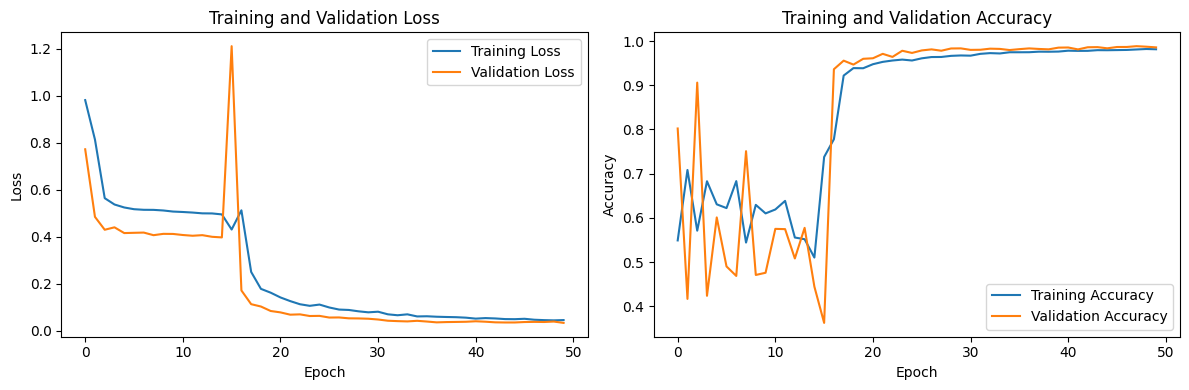

In [26]:
# Create a sample_weight array for pixel-wise class weighting

# Create an array of zeros with the same shape as y_train
# This will store a weight value for every pixel
sample_weights_array = np.zeros_like(y_train, dtype=np.float32)

# Loop over each class ID and its corresponding weight
for class_id, weight in class_weights.items():

    # Assign the class weight to all pixels belonging to this class
    sample_weights_array[y_train == class_id] = weight


# Define callbacks to improve traini

# Create a list of training callbacks
callbacks = [

    # Stop training early if validation loss stops improving
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',              # Track validation loss
        patience=10,                     # Wait 10 epochs before stopping
        restore_best_weights=True        # Restore best model weights
    ),

    # Reduce the learning rate when validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',              # Track validation loss
        factor=0.5,                      # Reduce learning rate by half
        patience=5,                      # Wait 5 epochs before reducing
        min_lr=1e-6                      # Minimum allowed learning rate
    )
]


# Train the model using pixel-wise sample weights

# Train the model on the training data
history = model.fit(

    # Input images for training
    X_train, y_train,

    # Use 20% of training data for validation
    validation_split=0.2,

    # Number of times the model sees the entire dataset
    epochs=50,        # Increased to allow better learning

    # Number of samples processed at once
    batch_size=4,

    # Apply pixel-wise weights to handle class imbalance
    sample_weight=sample_weights_array,

    # Use the defined callbacks during training
    callbacks=callbacks,

    # Display training progress
    verbose=1
)


# Plot training history

# Create a figure to display the plots
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)

# Plot training loss across epochs
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss across epochs
plt.plot(history.history['val_loss'], label='Validation Loss')

# Label the x-axis
plt.xlabel('Epoch')

# Label the y-axis
plt.ylabel('Loss')

# Display the legend
plt.legend()

# Add a title to the plot
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)

# Plot training accuracy across epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot validation accuracy across epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Label the x-axis
plt.xlabel('Epoch')

# Label the y-axis
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Add a title to the plot
plt.title('Training and Validation Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots on the screen
plt.show()


## 9. Test Evaluation

In [27]:
# Evaluate the trained model on the test dataset

# Compute the loss value and accuracy on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print the test accuracy formatted to 4 decimal places
print(f'Test accuracy: {test_acc:.4f}')


# Define the Dice coefficient metric

# Dice score measures how much the prediction overlaps with the ground truth
def dice_score(y_true, y_pred, smooth=1e-6):

    # Flatten the ground-truth mask into a 1D array
    y_true = y_true.flatten()

    # Flatten the predicted mask into a 1D array
    y_pred = y_pred.flatten()

    # Compute the number of pixels where prediction and ground truth overlap
    intersection = np.sum(y_true * y_pred)

    # Compute the Dice score with smoothing to avoid division by zero
    return (2.0 * intersection + smooth) / (
        np.sum(y_true) + np.sum(y_pred) + smooth
    )


# Define the Intersection over Union (IoU) metric

# IoU measures the overlap divided by the total combined area
def iou_score(y_true, y_pred, smooth=1e-6):

    # Compute the number of overlapping pixels
    intersection = np.sum(y_true * y_pred)

    # Compute the union of ground truth and prediction
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Compute the IoU score with smoothing
    return (intersection + smooth) / (union + smooth)


# Generate predictions on the test dataset

# Predict class probabilities for each pixel in the test images
y_pred_prob = model.predict(X_test)

# Convert probability maps to discrete class labels (0, 1, or 2)
y_pred = np.argmax(y_pred_prob, axis=-1)



# Compute Dice and IoU scores

# Create lists to store overall Dice and IoU scores per image
dice_scores = []
iou_scores = []

# Create a dictionary to store Dice scores for each class separately
dice_per_class = {0: [], 1: [], 2: []}

# Loop over each test image
for i in range(len(y_test)):

    # Compute Dice score treating all pore pixels as one class (foreground)
    dice_scores.append(
        dice_score(y_test[i] > 0, y_pred[i] > 0)
    )

    # Compute IoU score treating all pore pixels as one class
    iou_scores.append(
        iou_score(y_test[i] > 0, y_pred[i] > 0)
    )

    # Compute Dice score for each individual class
    for class_id in [0, 1, 2]:

        # Compare pixels belonging to the current class only
        dice_per_class[class_id].append(
            dice_score(
                y_test[i] == class_id,
                y_pred[i] == class_id
            )
        )


# Print overall evaluation metrics

# Print the mean Dice score across all test images
print(f'Mean Dice (overall): {np.mean(dice_scores):.4f}')

# Print the mean IoU score across all test images
print(f'Mean IoU (overall): {np.mean(iou_scores):.4f}')

# Print per-class Dice scores
print(f'\nPer-class Dice scores:')

# Print Dice score for background class
print(f'  Background (0): {np.mean(dice_per_class[0]):.4f}')

# Print Dice score for small pores
print(f'  Small pores (1): {np.mean(dice_per_class[1]):.4f}')

# Print Dice score for large pores
print(f'  Large pores (2): {np.mean(dice_per_class[2]):.4f}')



# Show prediction class distribution

# Print a header for prediction statistics
print(f'\nPrediction class distribution:')

# Loop over each class ID
for class_id in [0, 1, 2]:

    # Count how many pixels were predicted as this class
    count = np.sum(y_pred == class_id)

    # Compute the percentage of pixels belonging to this class
    percentage = 100 * count / y_pred.size

    # Print the count and percentage for the class
    print(f'  Class {class_id}: {count} pixels ({percentage:.2f}%)')


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9824 - loss: 0.0544
Test accuracy: 0.9824
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Mean Dice (overall): 0.9799
Mean IoU (overall): 0.9609

Per-class Dice scores:
  Background (0): 0.9851
  Small pores (1): 0.0696
  Large pores (2): 0.9927

Prediction class distribution:
  Class 0: 2250220 pixels (57.23%)
  Class 1: 49215 pixels (1.25%)
  Class 2: 1632725 pixels (41.52%)


## 10. Visualization

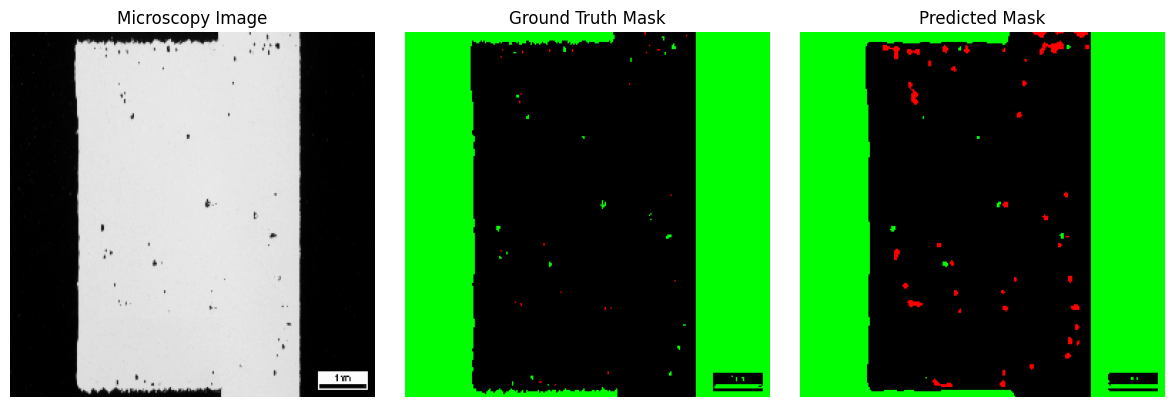

In [28]:
# Convert a class mask into a colored RGB image

def colorize_mask(mask):
    """Convert class mask to RGB visualization"""

    # Create an empty RGB image (height × width × 3 color channels)
    rgb = np.zeros(
        (mask.shape[0], mask.shape[1], 3),
        dtype=np.uint8
    )

    # Color pixels belonging to class 1 (small pores) in red
    rgb[mask == 1] = [255, 0, 0]

    # Color pixels belonging to class 2 (large pores) in green
    rgb[mask == 2] = [0, 255, 0]

    # Return the colored RGB mask
    return rgb


# Visualize prediction results

# Choose an index for visualization
# min() ensures the index does not go out of range
idx = min(9, len(X_test) - 1)

# Extract the grayscale test image and remove the channel dimension
image = X_test[idx].squeeze()

# Get the ground-truth mask corresponding to the image
gt_mask = y_test[idx]

# Get the predicted mask corresponding to the image
pred_mask = y_pred[idx]

# Create a new figure for visualization
plt.figure(figsize=(12, 4))


# Display the original microscopy image

plt.subplot(1, 3, 1)

# Set the title of the subplot
plt.title('Microscopy Image')

# Show the grayscale image
plt.imshow(image, cmap='gray')

# Hide axis ticks and labels
plt.axis('off')


# Display the ground truth segmentation mask


plt.subplot(1, 3, 2)

# Set the title of the subplot
plt.title('Ground Truth Mask')

# Show the colorized ground-truth mask
plt.imshow(colorize_mask(gt_mask))

# Hide axis ticks and labels
plt.axis('off')


# Display the predicted segmentation mask


plt.subplot(1, 3, 3)

# Set the title of the subplot
plt.title('Predicted Mask')

# Show the colorized predicted mask
plt.imshow(colorize_mask(pred_mask))

# Hide axis ticks and labels
plt.axis('off')


# Finalize and display the figure

# Automatically adjust spacing between subplots
plt.tight_layout()

# Display the visualization on the screen
plt.show()
